In [2]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 5000)

In [3]:
def get_info(link:str) -> list:
    url =link
    get_info = requests.get(url)
    info = eval(get_info.text)
    datalist=info['value']
    data=pd.DataFrame(datalist)
    return data

In [4]:
def Integrity_Check(df):
    print('Is there any null value in the dataset')
    print(df.isna().all().all())
    print('Every year has all country data?')
    print(df.groupby(['DIM_YEAR_CODE'])['DIM_COUNTRY_CODE'].nunique())
    print('which country provide more data?')
    print(df.groupby(['DIM_COUNTRY_CODE'])['DIM_YEAR_CODE'].count().sort_values(ascending=False))
    print('How many cause of death in the dataset? Any herirarchy?')
    print(list[df['DIM_GHECAUSE_TITLE'].unique()])
    print('which cause of death has more country data? ')
    print(df.groupby(['DIM_GHECAUSE_TITLE'])['DIM_COUNTRY_CODE'].nunique().sort_values(ascending=False))

In [5]:
def dataframe_intergration(df):
    df['COUNTRY_NAME']=None
    df['INCOME_GROUP']=None
    df['REGION']=None
    df['mortality_type']=None
    df['INCOME_GROUP_LEVEL']=None
    df['DIM_GHECAUSE_CODE']=df['DIM_GHECAUSE_CODE'].astype('int')
    df['DIM_YEAR_CODE']=df['DIM_YEAR_CODE'].astype('int')
    income=pd.read_csv("income groupyyy.csv",encoding='ansi')
    region=pd.read_csv("country_region.csv")

    country_list=list(df.DIM_COUNTRY_CODE.unique())

    for country in country_list:
        for year in range(2000,2020):
            #print(country,year)
            income_group=income.loc[income['cty_code'] == country, str(year)].tolist()
            country_name=income.loc[income['cty_code'] == country, 'country'].tolist()
            df.loc[(df['DIM_COUNTRY_CODE']==country) & (df['DIM_YEAR_CODE']==year),'INCOME_GROUP']=income_group[0]
            df.loc[(df['DIM_COUNTRY_CODE']==country) & (df['DIM_YEAR_CODE']==year),'COUNTRY_NAME']=country_name[0]
    countryname_list=list(df.COUNTRY_NAME.unique())
    for country in countryname_list:
        belong_region=region.loc[region['Country']==country,'Region'].tolist()
        #print(country,belong_region)
        try:
            df.loc[df['COUNTRY_NAME']==country,'REGION']=belong_region[0]
        except:
            continue

    df.loc[df['DIM_GHECAUSE_CODE']<600,'mortality_type']='communicable'
    df.loc[(df['DIM_GHECAUSE_CODE']>600) & (df['DIM_GHECAUSE_CODE']<1510),'mortality_type']='noncommunicable'
    df.loc[df['DIM_GHECAUSE_CODE']>1510,'mortality_type']='Injuries'

    # for the correlation, transform the income_group(str) to income_group_level(int)
    df.loc[df['INCOME_GROUP']=='H','INCOME_GROUP_LEVEL']=4
    df.loc[df['INCOME_GROUP']=='UM','INCOME_GROUP_LEVEL']=3
    df.loc[df['INCOME_GROUP']=='LM','INCOME_GROUP_LEVEL']=2
    df.loc[df['INCOME_GROUP']=='L','INCOME_GROUP_LEVEL']=1
    df.loc[df['INCOME_GROUP']=='..','INCOME_GROUP_LEVEL']=0
    df['INCOME_GROUP_LEVEL']=df['INCOME_GROUP_LEVEL'].astype('int')
    return df

In [6]:
def world_mortality_trend(all_data):
    worldly_mortality_trend=all_data.groupby(['DIM_YEAR_CODE','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    worldly=worldly_mortality_trend.groupby(['DIM_YEAR_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    worldly['death_per1000']=worldly['VAL_DEATHS_COUNT_NUMERIC']/worldly['ATTR_POPULATION_NUMERIC']*1000

    fig = plt.figure(figsize = (14,7))
    plt.plot(worldly['DIM_YEAR_CODE'],
         worldly['death_per1000'],
         linestyle = '-',
         linewidth = 2,
         color = 'steelblue',

         markeredgecolor='black',
         markerfacecolor='brown')

    plt.title('Globally mortality rate')
    plt.xlabel('Year')
    plt.ylabel('rate( per 1000 population)')
    plt.ylim((4, 10))
    plt.xticks(range(2000,2020,1))
    return worldly

In [7]:
def ratetrend_incomegroup(dataset):#done
    causebyincome=dataset.sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['INCOME_GROUP','DIM_YEAR_CODE','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC','INCOME_GROUP_LEVEL']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum,'INCOME_GROUP_LEVEL':np.max})
    causebyincome=causebyincome.groupby(['INCOME_GROUP','DIM_YEAR_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC','INCOME_GROUP_LEVEL']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum,'INCOME_GROUP_LEVEL':np.max})
    causebyincome['death_per1000']=causebyincome['VAL_DEATHS_COUNT_NUMERIC']/causebyincome['ATTR_POPULATION_NUMERIC']*1000
    causebyincome=causebyincome[causebyincome['INCOME_GROUP']!='..']
    return causebyincome

In [8]:
def Topdeathtype_incomegroup_year(dataset,  year):   #done
    causebyincome=dataset[(dataset['DIM_YEAR_CODE']==year)].sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['INCOME_GROUP','mortality_type','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum})

    causebyincome1=causebyincome.groupby(['INCOME_GROUP','mortality_type'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    causebyincome1['death_per1000']=causebyincome1['VAL_DEATHS_COUNT_NUMERIC']/causebyincome1['ATTR_POPULATION_NUMERIC']*1000
    causebyincome1=causebyincome1[causebyincome1['INCOME_GROUP']!='..']
    causebyincome1 = causebyincome1.pivot(index='INCOME_GROUP', columns='mortality_type', values='death_per1000')
    colors = ["#006D2C", "#31A354","#74C476"]
    causebyincome1.loc[:,['Injuries','communicable', 'noncommunicable']].plot.bar(stacked=True, color=colors, figsize=(10,7),ylim=([0,10]))
    return causebyincome1

In [9]:
def Topcause_trend(dataset,year,income_group='All',category='All'):
    top10cause=Topcause_year(dataset,year,income_group,category)
    disease_list=list(top10cause['DIM_GHECAUSE_TITLE'])

    if income_group=='All':
        incomegroup=['H','L','UM','LM']
    else:
        incomegroup=[income_group]
    if category=='All':
        mortalitycategory=['communicable','noncommunicable','Injuries']
    else:
        mortalitycategory=[category]

    df=dataset[(dataset['INCOME_GROUP'].isin(incomegroup))&(dataset['mortality_type'].isin(mortalitycategory))&(dataset['DIM_GHECAUSE_TITLE'].isin(disease_list))].groupby(['DIM_GHECAUSE_TITLE','DIM_YEAR_CODE','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum})

    df1=df.groupby(['DIM_GHECAUSE_TITLE','DIM_YEAR_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum,'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    df1['death_per1000']=df1['VAL_DEATHS_COUNT_NUMERIC']/df1['ATTR_POPULATION_NUMERIC']*1000
    df1 = df1.pivot(index='DIM_YEAR_CODE', columns='DIM_GHECAUSE_TITLE', values='death_per1000')
    plot=df1.plot(kind='line', xlabel='year',ylabel='the number of death per 1000 ',
                 title='Death rate trend from 2000-2019\nincome group='+income_group+' Mortality type='+category,
                 figsize=(10, 7),legend=True,xticks=(range(2000,2020,1)))
    plot.legend(bbox_to_anchor=(1.5, 1))

    return df1

In [10]:
def Topcause_year(dataset, year,income_group='All',category='All'):#done
    if income_group=='All':
        incomegroup=['H','L','UM','LM']
    else:
        incomegroup=[income_group]
    if category=='All':
        mortalitycategory=['communicable','noncommunicable','Injuries']
    else:
        mortalitycategory=[category]

    df=dataset[(dataset['DIM_YEAR_CODE']==year)&(dataset['INCOME_GROUP'].isin(incomegroup))&(dataset['mortality_type'].isin(mortalitycategory))].sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['DIM_GHECAUSE_TITLE'],as_index=False)[['VAL_DEATHS_COUNT_NUMERIC','mortality_type']].agg({'VAL_DEATHS_COUNT_NUMERIC': np.sum,'mortality_type':np.max}).nlargest(10,'VAL_DEATHS_COUNT_NUMERIC')

    plt.bar(df['DIM_GHECAUSE_TITLE'],df['VAL_DEATHS_COUNT_NUMERIC'])
    plt.xticks(rotation=270)
    plt.title('10 leading disease\n income group='+income_group+', Mortality type='+category)
    plt.xlabel('Disease')
    plt.ylabel('Number of death')
    plt.show()
    return df

In [11]:
def deathtypetrend(dataset, income_group='ALL'):
    if income_group=='ALL':
        incomegroup=['..','H','L','UM','LM']
    else:
        incomegroup=[income_group]
    causebyincome=dataset[dataset['INCOME_GROUP'].isin(incomegroup)].sort_values(['VAL_DEATHS_COUNT_NUMERIC'],ascending=False).groupby(['DIM_YEAR_CODE','mortality_type','DIM_COUNTRY_CODE'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.max,'VAL_DEATHS_COUNT_NUMERIC': np.sum})

    causebyincome1=causebyincome.groupby(['DIM_YEAR_CODE','mortality_type'],as_index=False)[['ATTR_POPULATION_NUMERIC','VAL_DEATHS_COUNT_NUMERIC']].agg({'ATTR_POPULATION_NUMERIC':np.sum, 'VAL_DEATHS_COUNT_NUMERIC': np.sum})
    causebyincome1['death_per1000']=causebyincome1['VAL_DEATHS_COUNT_NUMERIC']/causebyincome1['ATTR_POPULATION_NUMERIC']*1000
    causebyincome1 = causebyincome1.pivot(index='DIM_YEAR_CODE', columns='mortality_type', values='death_per1000')
    causebyincome1.plot(kind='line', xlabel='year',ylabel='death_per1000',
                 title='three causes of death trend from 2000-2019 in the income_group='+income_group,
                 figsize=(10, 7),legend=True,xticks=(range(2000,2020,1)))
    return causebyincome1

In [12]:
all_data=get_info('https://frontdoor-l4uikgap6gz3m.azurefd.net/DEX_CMS/GHE_FULL?&$orderby=VAL_DEATHS_RATE100K_NUMERIC%20desc&$select=DIM_COUNTRY_CODE,DIM_GHECAUSE_CODE,DIM_GHECAUSE_TITLE,DIM_YEAR_CODE,DIM_SEX_CODE,DIM_AGEGROUP_CODE,VAL_DALY_COUNT_NUMERIC,VAL_DEATHS_COUNT_NUMERIC,ATTR_POPULATION_NUMERIC,VAL_DALY_RATE100K_NUMERIC,VAL_DEATHS_RATE100K_NUMERIC&$filter=FLAG_RANKABLE%20eq%201%20and%20DIM_SEX_CODE%20eq%20%27BTSX%27%20and%20DIM_AGEGROUP_CODE%20eq%20%27ALLAges%27')
#all_data.to_csv('all_data.csv',sep=',', index=False)
dataframe_intergration(all_data)
Integrity_Check(all_data)
# Dataset doesnt have null value, Every country(number of countries:183) has value in each year (year range:2000-2019)

Is there any null value in the dataset
False
Every year has all country data?
DIM_YEAR_CODE
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2013    183
2014    183
2015    183
2016    183
2017    183
2018    183
2019    183
Name: DIM_COUNTRY_CODE, dtype: int64
which country provide more data?
DIM_COUNTRY_CODE
RUS    927
SOM    901
CAF    884
UKR    879
LTU    879
      ... 
SAU    370
BHR    351
ARE    319
QAT    285
KWT    261
Name: DIM_YEAR_CODE, Length: 183, dtype: int64
How many cause of death in the dataset? Any herirarchy?
list[array(['Natural disasters', 'HIV/AIDS', 'Ischaemic heart disease',
       'Collective violence and legal intervention', 'Stroke', 'Malaria',
       'Diarrhoeal diseases', 'Lower respiratory infections', 'Measles',
       'Hypertensive heart disease',
       'Cardiomyopathy, myocarditis, endocarditis',
       'Protein-energy malnutrition', 'Neonatal c

,DIM_YEAR_CODE,ATTR_POPULATION_NUMERIC,VAL_DEATHS_COUNT_NUMERIC,death_per1000
0,2000,6.116994e+09,45387904.74,7.419969
1,2001,6.197259e+09,45587156.12,7.356020
2,2002,6.260956e+09,46009360.66,7.348616
3,2003,6.343724e+09,46220884.71,7.286081
4,2004,6.426602e+09,45919133.15,7.145165
5,2005,6.510923e+09,45712089.62,7.020831
6,2006,6.597804e+09,45309802.67,6.867406
7,2007,6.663735e+09,45261094.74,6.792151
8,2008,6.751347e+09,45671698.34,6.764827
9,2009,6.840801e+09,45021032.21,6.581251


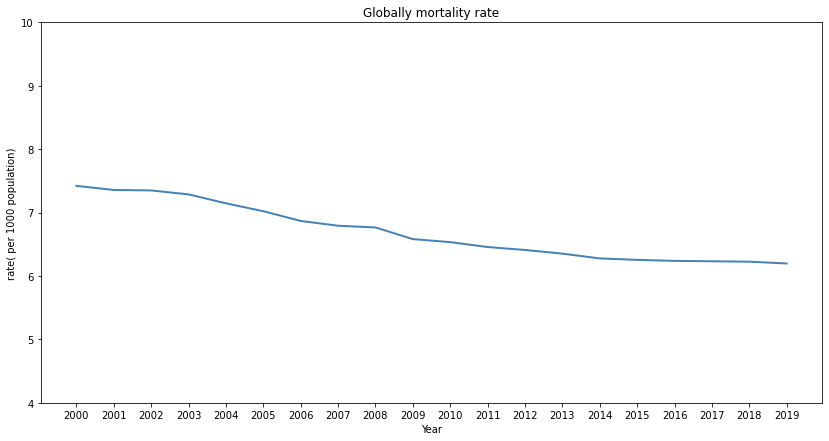

In [13]:
world_mortality_trend(all_data)
#it shows that the world-wide death rate is getting lower.

                          DIM_YEAR_CODE  ATTR_POPULATION_NUMERIC  VAL_DEATHS_COUNT_NUMERIC  INCOME_GROUP_LEVEL  death_per1000
DIM_YEAR_CODE              1.000000e+00                 0.128617                  0.017891        6.149634e-15      -0.261604
ATTR_POPULATION_NUMERIC    1.286170e-01                 1.000000                  0.964699       -2.439815e-01      -0.183111
VAL_DEATHS_COUNT_NUMERIC   1.789072e-02                 0.964699                  1.000000       -3.190849e-01       0.052124
INCOME_GROUP_LEVEL         6.149634e-15                -0.243981                 -0.319085        1.000000e+00      -0.215330
death_per1000             -2.616039e-01                -0.183111                  0.052124       -2.153299e-01       1.000000


'it shows that the correlation between income group and death rate, the cor= -0.2, means the the high income country has a lower death rate\nBeside, the chart provide the death rate trend in different income group\ntwo interesting trend that we can discuss later:\n1.upper middle group has a peak around 2005, what happened?\n2.there is a clear declined trend of LOW income country, what led to this trend?\n'

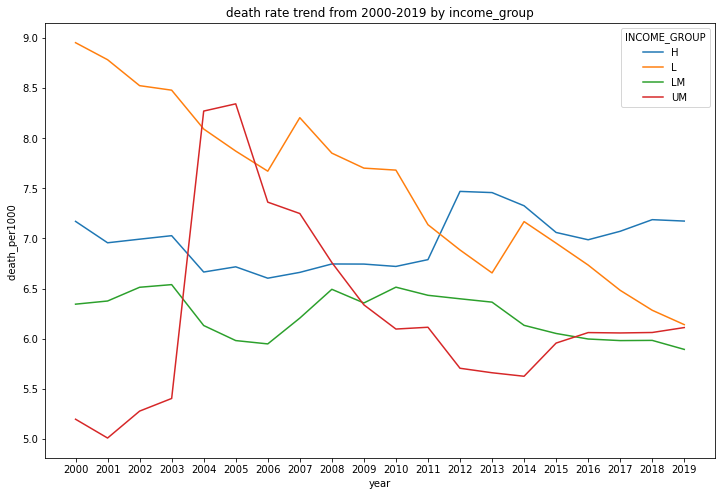

In [14]:
d=ratetrend_incomegroup(all_data)
print(d.corr())

plotdata=d.pivot(index='DIM_YEAR_CODE', columns='INCOME_GROUP', values='death_per1000')
plotdata.plot(kind='line', xlabel='year',ylabel='death_per1000 ',
                 title='death rate trend from 2000-2019 by income_group',
                 figsize=(12, 8),legend=True,xticks=(range(2000,2020,1)))


'''it shows that the correlation between income group and death rate, the cor= -0.2, means the the high income country has a lower death rate
Beside, the chart provide the death rate trend in different income group
two interesting trend that we can discuss later:
1.upper middle group has a peak around 2005, what happened?
2.there is a clear declined trend of LOW income country, what led to this trend?
'''

mortality_type,Injuries,communicable,noncommunicable
DIM_YEAR_CODE,,,
2000,0.555422,2.428596,4.435950
2001,0.542020,2.355600,4.458399
2002,0.541455,2.295653,4.511509
2003,0.537326,2.219068,4.529687
2004,0.566064,2.124786,4.454315
2005,0.534847,2.045741,4.440244
2006,0.515241,1.951435,4.400731
2007,0.508437,1.868008,4.415707
2008,0.542141,1.788917,4.433769


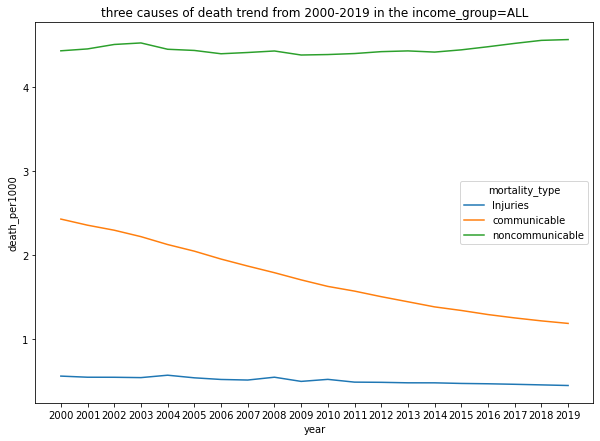

In [15]:
deathtypetrend(all_data)

2004


'there death types, it matched the paper1:\n1. When in 2004, Communicable diseases remain an important cause of death in lowincome countries.\n2. Confirm the growing importance of noncommunicable diseases in most low- and middle-income countries.'

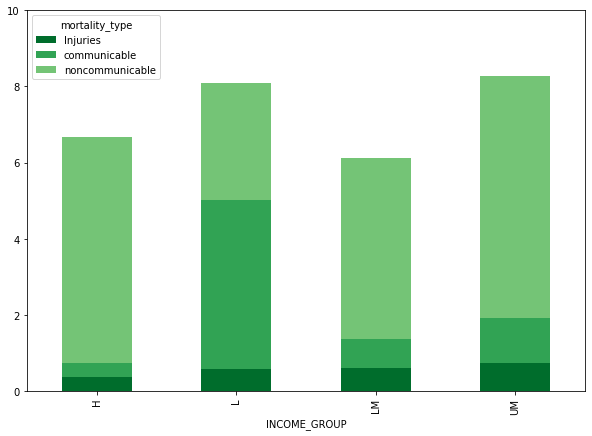

In [18]:

print('2004')
Topdeathtype_incomegroup_year(all_data,2004)

'''there death types, it matched the paper1:
1. When in 2004, Communicable diseases remain an important cause of death in lowincome countries.
2. Confirm the growing importance of noncommunicable diseases in most low- and middle-income countries.'''

mortality_type,Injuries,communicable,noncommunicable
DIM_YEAR_CODE,,,
2000,0.365271,0.440385,6.365222
2001,0.370433,0.379664,6.207204
2002,0.371218,0.394783,6.227248
2003,0.364973,0.406585,6.256538
2004,0.359681,0.379424,5.926381
2005,0.358476,0.410874,5.948071
2006,0.355171,0.381468,5.867346
2007,0.353953,0.385252,5.922796
2008,0.351710,0.394857,5.999267


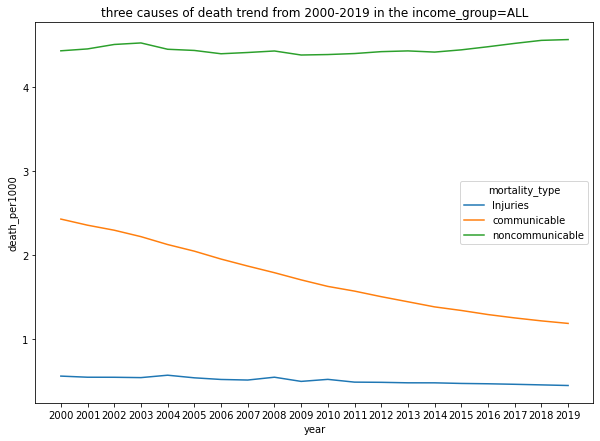

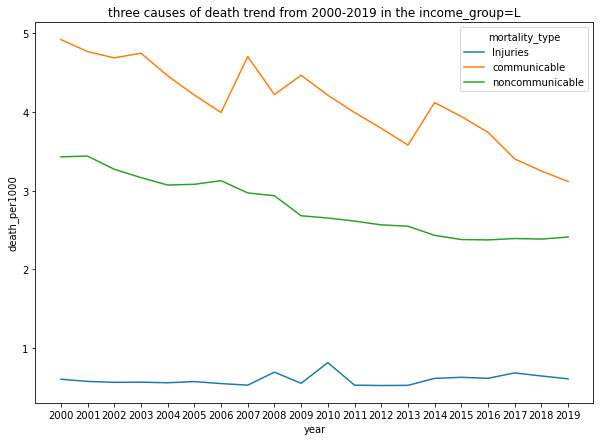

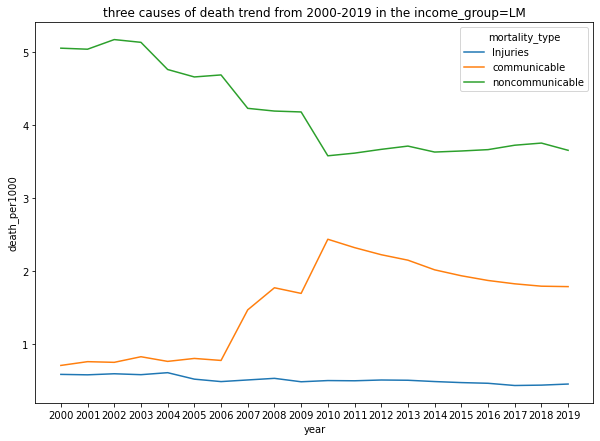

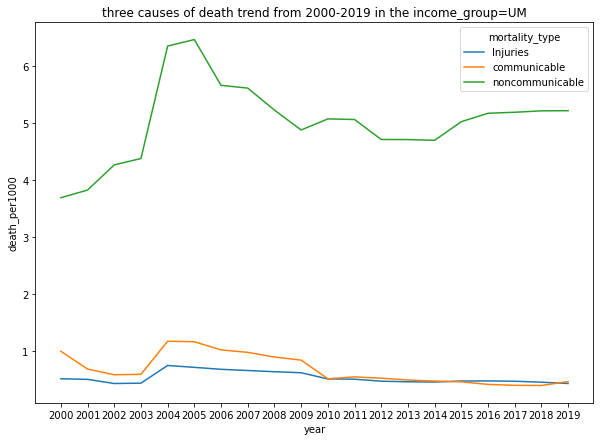

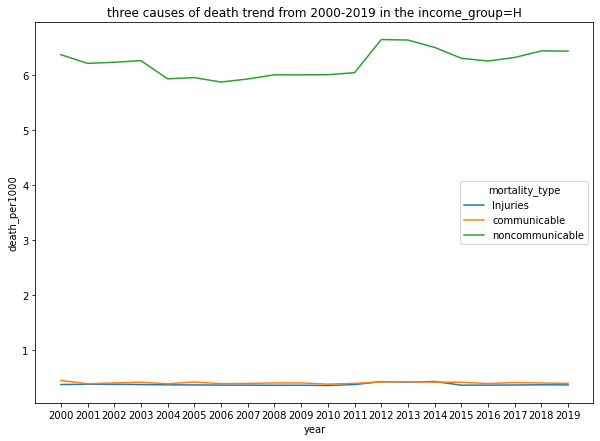

In [341]:

deathtypetrend(all_data,income_group='L')
deathtypetrend(all_data,income_group='LM')
deathtypetrend(all_data,income_group='UM')
deathtypetrend(all_data,income_group='H')
#deathtypetrend(all_data,income_group='H')

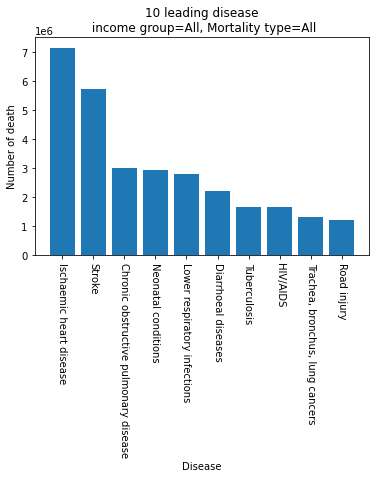


Globally leading specific disease

                        DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC   mortality_type
39                Ischaemic heart disease                7146080.30  noncommunicable
74                                 Stroke                5719279.57  noncommunicable
14  Chronic obstructive pulmonary disease                2980425.33  noncommunicable
55                    Neonatal conditions                2908989.60     communicable
45           Lower respiratory infections                2792345.83     communicable
23                    Diarrhoeal diseases                2196327.82     communicable
80                           Tuberculosis                1643390.37     communicable
35                               HIV/AIDS                1637181.38     communicable
79        Trachea, bronchus, lung cancers                1305485.42  noncommunicable
68                            Road injury                1209615.11         Injuries


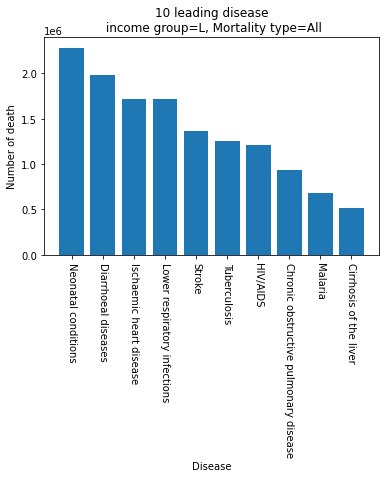



Low-income leading specific disease

                         DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC   mortality_type
46                    Neonatal conditions                2282097.77     communicable
19                    Diarrhoeal diseases                1985220.41     communicable
32                Ischaemic heart disease                1719989.17  noncommunicable
37           Lower respiratory infections                1712520.72     communicable
64                                 Stroke                1362827.50  noncommunicable
69                           Tuberculosis                1256826.33     communicable
29                               HIV/AIDS                1205784.75     communicable
11  Chronic obstructive pulmonary disease                 928380.57  noncommunicable
39                                Malaria                 684727.79     communicable
12                 Cirrhosis of the liver                 508857.90  noncommunicable


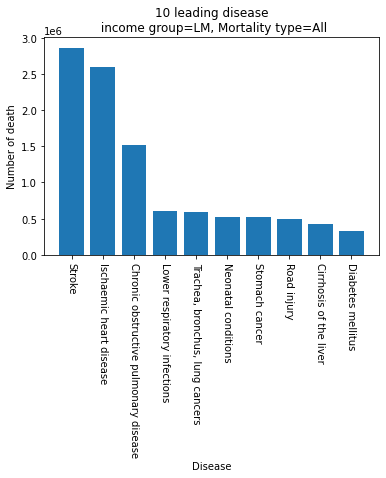



Low-middle income leading specific disease

                        DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC   mortality_type
66                                 Stroke                2865417.24  noncommunicable
33                Ischaemic heart disease                2602827.33  noncommunicable
11  Chronic obstructive pulmonary disease                1514058.59  noncommunicable
39           Lower respiratory infections                 598310.76     communicable
71        Trachea, bronchus, lung cancers                 593878.31  noncommunicable
48                    Neonatal conditions                 525378.13     communicable
65                         Stomach cancer                 522433.03  noncommunicable
60                            Road injury                 499816.83         Injuries
12                 Cirrhosis of the liver                 426588.86  noncommunicable
19                      Diabetes mellitus                 321237.29  noncommunicable


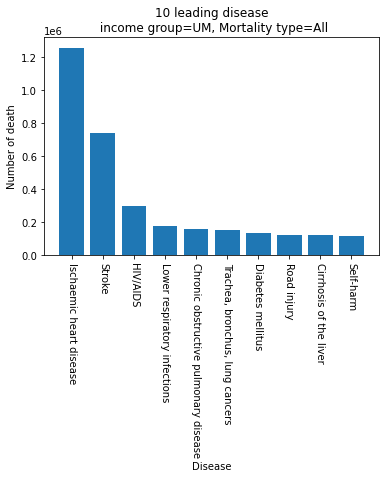



Upper-middle income leading specific disease

                        DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC   mortality_type
31                Ischaemic heart disease                1255168.82  noncommunicable
63                                 Stroke                 737223.40  noncommunicable
27                               HIV/AIDS                 293731.64     communicable
37           Lower respiratory infections                 174282.27     communicable
10  Chronic obstructive pulmonary disease                 156083.72  noncommunicable
66        Trachea, bronchus, lung cancers                 151164.66  noncommunicable
16                      Diabetes mellitus                 129910.40  noncommunicable
58                            Road injury                 121691.66         Injuries
11                 Cirrhosis of the liver                 120793.72  noncommunicable
59                              Self-harm                 115063.54         Injuries


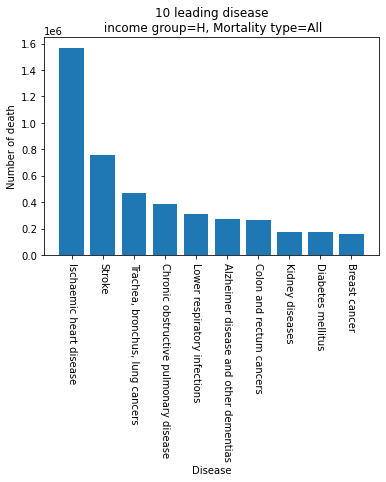



High income leading specific disease

                        DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC   mortality_type
28                Ischaemic heart disease                1568094.98  noncommunicable
56                                 Stroke                 753811.43  noncommunicable
57        Trachea, bronchus, lung cancers                 466030.38  noncommunicable
9   Chronic obstructive pulmonary disease                 381902.45  noncommunicable
34           Lower respiratory infections                 307232.08     communicable
2   Alzheimer disease and other dementias                 272209.51  noncommunicable
12               Colon and rectum cancers                 261717.11  noncommunicable
30                        Kidney diseases                 173914.38  noncommunicable
15                      Diabetes mellitus                 172913.19  noncommunicable
6                           Breast cancer                 157366.70  noncommunicable


'As may be expected from the very different distributions of deaths by\nage and sex, there are major differences in the ranking of causes\nbetween high- and low-income countries (Table 4). In low-income\ncountries, the dominant causes are infectious and parasitic diseases\n(including malaria), and neonatal causes. In the high-income countries,\n9 of the 10 leading causes of death are non-communicable conditions,\nincluding the four types of cancer. In the middle-income countries, the\n10 leading causes of death are again dominated by non-communicable\nconditions; they also include road traffic accidents as the sixth most\ncommon cause.'

In [324]:
#leading cause of death disease in 2004 each income group
print('\nGlobally leading specific disease\n\n',Topcause_year(all_data,2004))

print('\n\nLow-income leading specific disease\n\n ',Topcause_year(all_data,2004,income_group='L'))
print('\n\nLow-middle income leading specific disease\n\n',Topcause_year(all_data,2004,income_group='LM'))
print('\n\nUpper-middle income leading specific disease\n\n',Topcause_year(all_data,2004,income_group='UM'))
print('\n\nHigh income leading specific disease\n\n',Topcause_year(all_data,2004,income_group='H'))


'''As may be expected from the very different distributions of deaths by
age and sex, there are major differences in the ranking of causes
between high- and low-income countries (Table 4). In low-income
countries, the dominant causes are infectious and parasitic diseases
(including malaria), and neonatal causes. In the high-income countries,
9 of the 10 leading causes of death are non-communicable conditions,
including the four types of cancer. In the middle-income countries, the
10 leading causes of death are again dominated by non-communicable
conditions; they also include road traffic accidents as the sixth most
common cause.'''

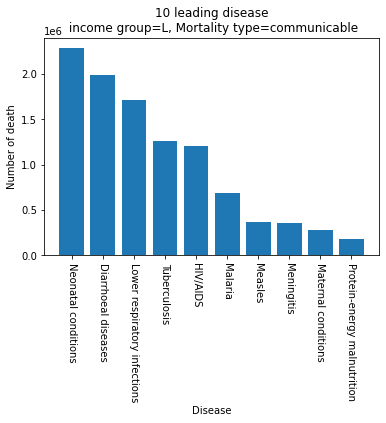

DIM_GHECAUSE_TITLE,Diarrhoeal diseases,HIV/AIDS,Lower respiratory infections,Malaria,Maternal conditions,Measles,Meningitis,Neonatal conditions,Protein-energy malnutrition,Tuberculosis
DIM_YEAR_CODE,,,,,,,,,,
2000,1.014153,0.563578,0.799579,0.953056,0.148888,0.237861,0.170823,1.021584,0.127931,0.576313
2001,0.957526,0.588369,0.766522,0.936361,0.141604,0.219837,0.166772,0.986563,0.119596,0.568489
2002,0.916859,0.618752,0.757785,0.914238,0.134951,0.182011,0.161421,0.974327,0.113322,0.566550
2003,0.902256,0.617689,0.759622,0.864391,0.133890,0.222784,0.168756,0.995772,0.088209,0.550607
2004,0.831418,0.613452,0.715961,0.923915,0.126002,0.184976,0.157722,0.954086,0.078615,0.525447
2005,0.787261,0.564162,0.691266,0.832993,0.117319,0.168720,0.153741,0.920845,0.073847,0.505080
2006,0.769441,0.517724,0.683017,0.829932,0.109994,0.107302,0.140964,0.888285,0.116026,0.480697
2007,0.680186,0.952860,0.848966,0.821058,0.157095,0.073089,0.214829,1.010465,0.112924,0.480923
2008,0.553496,0.880727,0.750407,0.621452,0.157162,0.112545,0.206095,0.861129,0.132902,0.477890


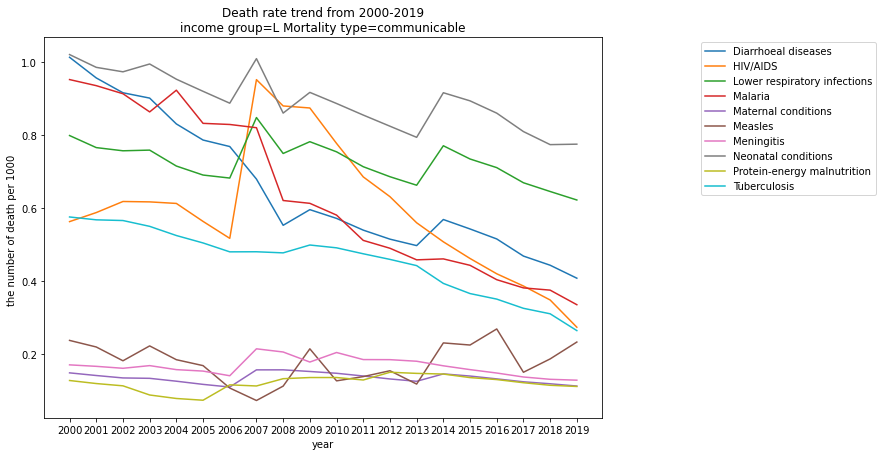

In [344]:
Topcause_trend(all_data,2004,income_group='L',category='communicable')

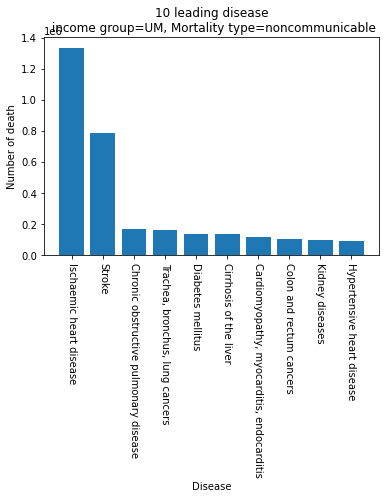

DIM_GHECAUSE_TITLE,"Cardiomyopathy, myocarditis, endocarditis",Chronic obstructive pulmonary disease,Cirrhosis of the liver,Colon and rectum cancers,Diabetes mellitus,Hypertensive heart disease,Ischaemic heart disease,Kidney diseases,Stroke,"Trachea, bronchus, lung cancers"
DIM_YEAR_CODE,,,,,,,,,,
2000,0.084658,0.241087,0.152458,0.111938,0.231031,0.108933,1.035816,0.151511,0.621173,0.187986
2001,0.094308,0.254490,0.152815,0.109720,0.219039,0.098518,1.169094,0.155691,0.650464,0.181100
2002,0.089904,0.246862,0.180225,0.194081,0.239661,0.098233,1.393458,0.185880,0.660254,0.228116
2003,0.080397,0.263019,0.180439,0.136245,0.254669,0.108683,1.417670,0.195335,0.663472,0.228919
2004,0.276466,0.271222,0.209899,0.163359,0.225741,0.132579,2.181066,0.162799,1.281049,0.264943
2005,0.293034,0.274918,0.225481,0.167143,0.228349,0.150325,2.217420,0.164221,1.301958,0.271419
2006,0.253180,0.265274,0.193258,0.142879,0.225493,0.152399,1.852111,0.152833,1.135400,0.234342
2007,0.244979,0.270732,0.191394,0.140523,0.230196,0.151973,1.839784,0.156592,1.105661,0.231061
2008,0.249642,0.251713,0.182186,0.133629,0.224412,0.153723,1.698171,0.158564,1.001805,0.217172


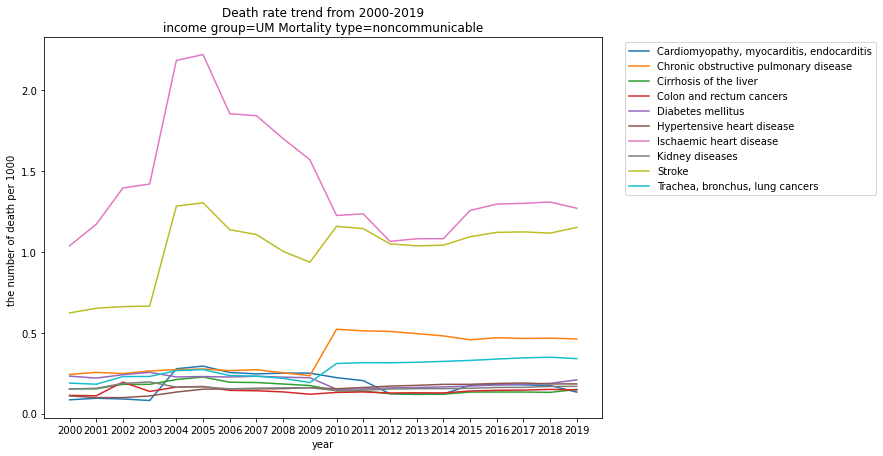

In [19]:
Topcause_trend(all_data,2005,income_group='UM',category='noncommunicable')

In [200]:
print(Topcause_year(all_data,2004))
print(Topcause_year(all_data,2004,income_group='L',category='noncommunicable'))


                       DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC
39                Ischaemic heart disease                7146080.30
74                                 Stroke                5719279.57
14  Chronic obstructive pulmonary disease                2980425.33
55                    Neonatal conditions                2908989.60
45           Lower respiratory infections                2792345.83
23                    Diarrhoeal diseases                2196327.82
                       DIM_GHECAUSE_TITLE  VAL_DEATHS_COUNT_NUMERIC
16                Ischaemic heart disease                1719989.17
35                                 Stroke                1362827.50
8   Chronic obstructive pulmonary disease                 928380.57
9                  Cirrhosis of the liver                 508857.90
12                      Diabetes mellitus                 368454.94
11                   Congenital anomalies                 332793.53
